# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tq import ROOT_PATH

In [2]:
def strip_unit(a):
    if a.endswith('[kWh]'):
        a = a[:-5]
    elif a.endswith('[kVArh]'):
        a = a[:-7]
    return a
    
def strip_unit_tup(x):
    a, b = x
    a = strip_unit(a)
    return (a, b)

In [3]:
data_path = ROOT_PATH / 'data' / 'tetarom' / 'clean_merged_data.feather'  #  <-- Inlocuieste aici locatia fisierului

In [4]:
tetarom_df = pd.read_feather(data_path)
tetarom_df.columns = tetarom_df.columns.map(strip_unit_tup)

df = tetarom_df.loc[:, ['EA+', 'EA-']]
df['EA-'] *= -1
df = df.T.groupby('location').sum().T
ea = df

# Raw overview

Todo:
- EA+/- aceeasi culoare pentru fiecare statie
- ER+/- versiuni de aceeasi culoare pentru fiecare locatie
- Zoom in pe o perioada din chart, e.g.: luna Decembrie

<Axes: xlabel='time'>

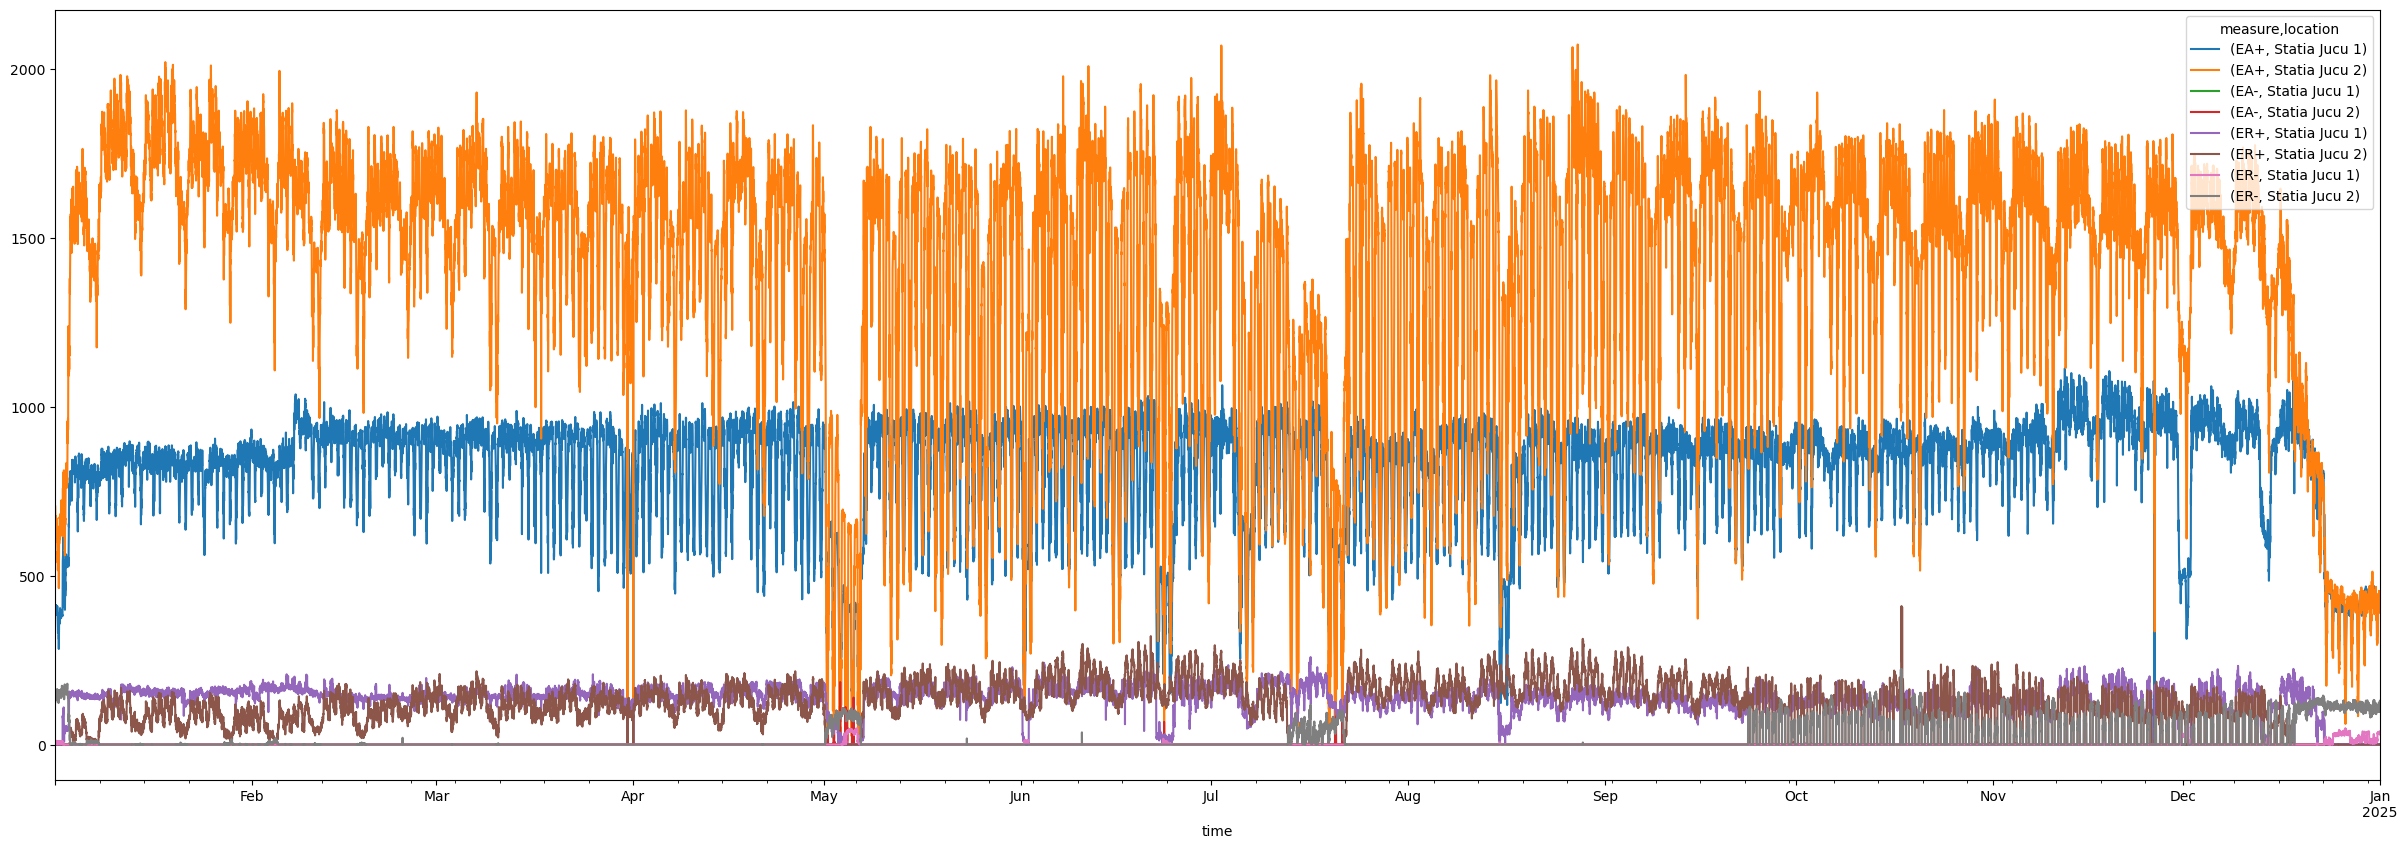

In [5]:
tetarom_df.plot(figsize=(30, 10))

# Weekly consumption

Todo:
- Axa Y trebuie sa arate kWh/MWh in loc de scientific format (1e6)
- Selector pentru perioada de resample (Day, Week, Month)

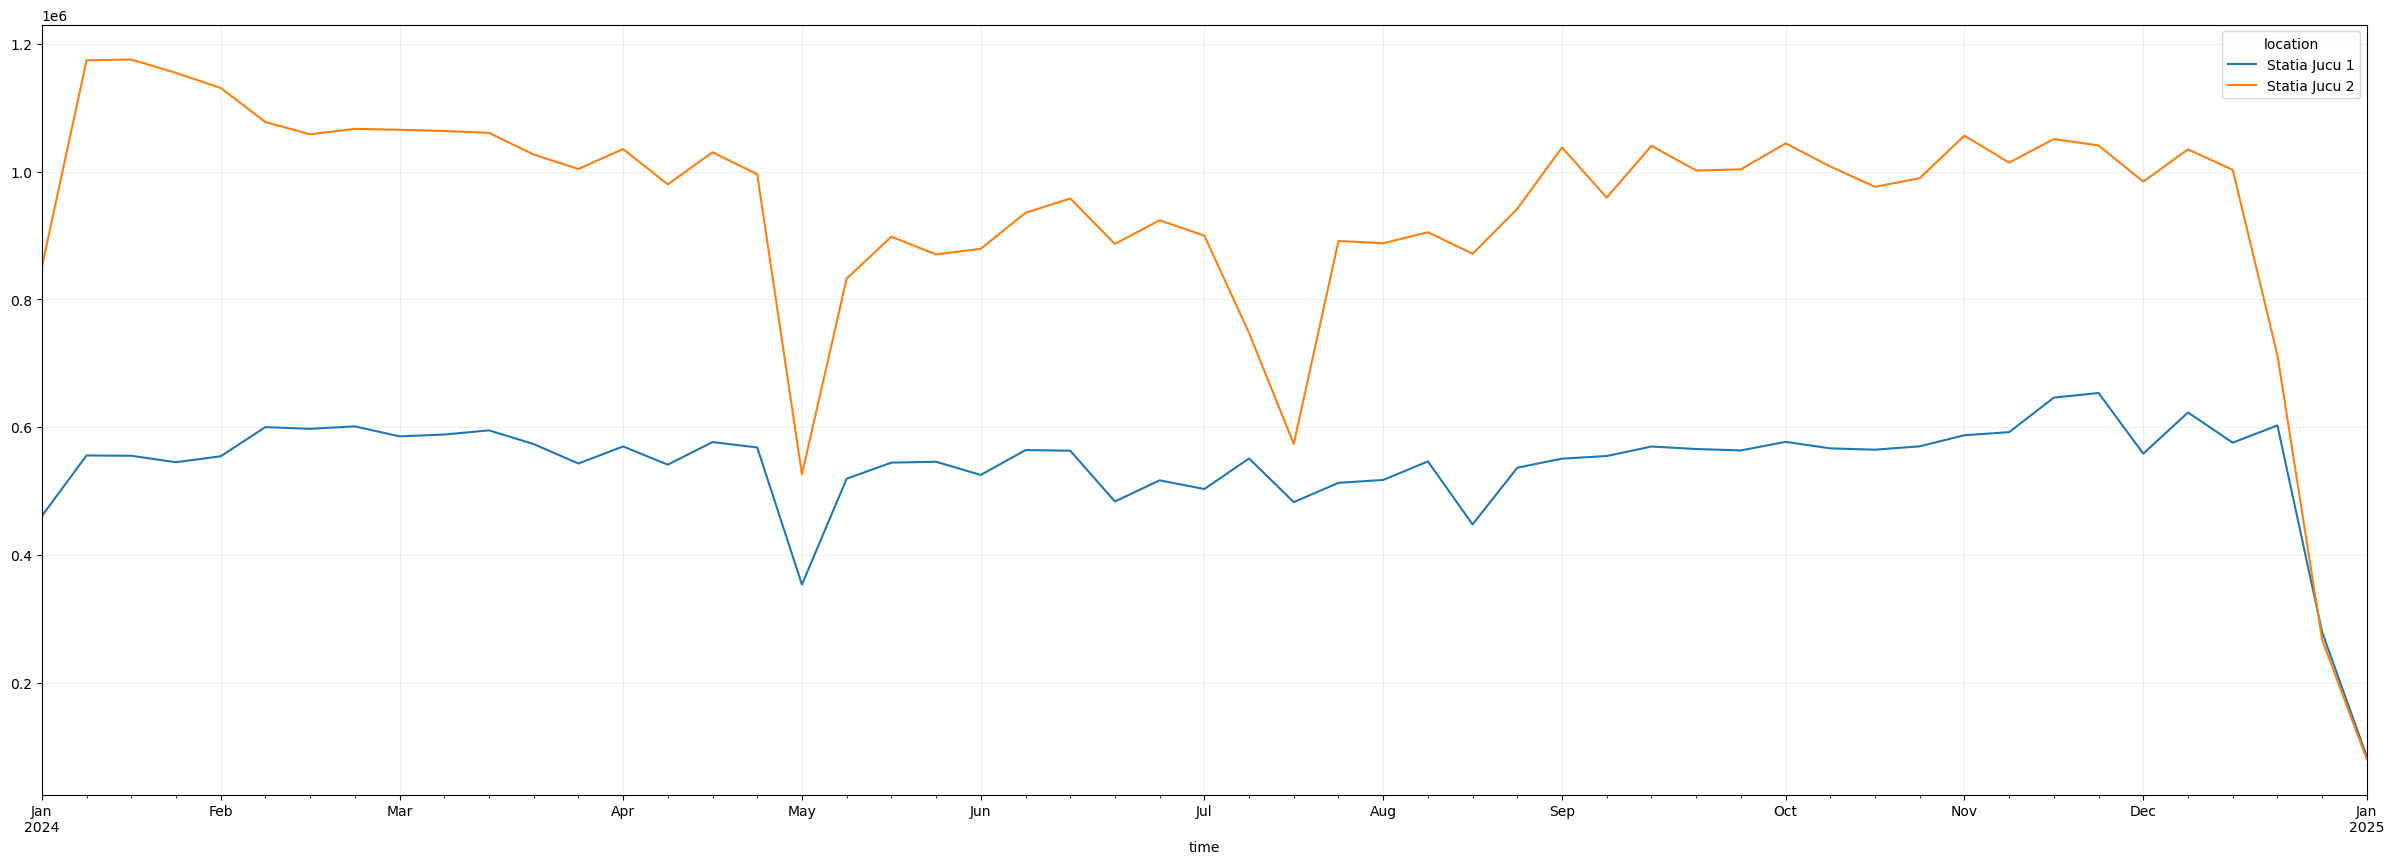

In [6]:
ea.resample('W').sum().plot(figsize=(30, 10))
plt.grid(alpha=.2)

# Intra-week consumption

Trei optiuni:
- Statia Jucu 1
- Statia Jucu 2
- Total

Todo:
- axa X sa scrie Mon/Tue/etc (in loc de 1/2/etc days)
- axa Y unitate in kWh

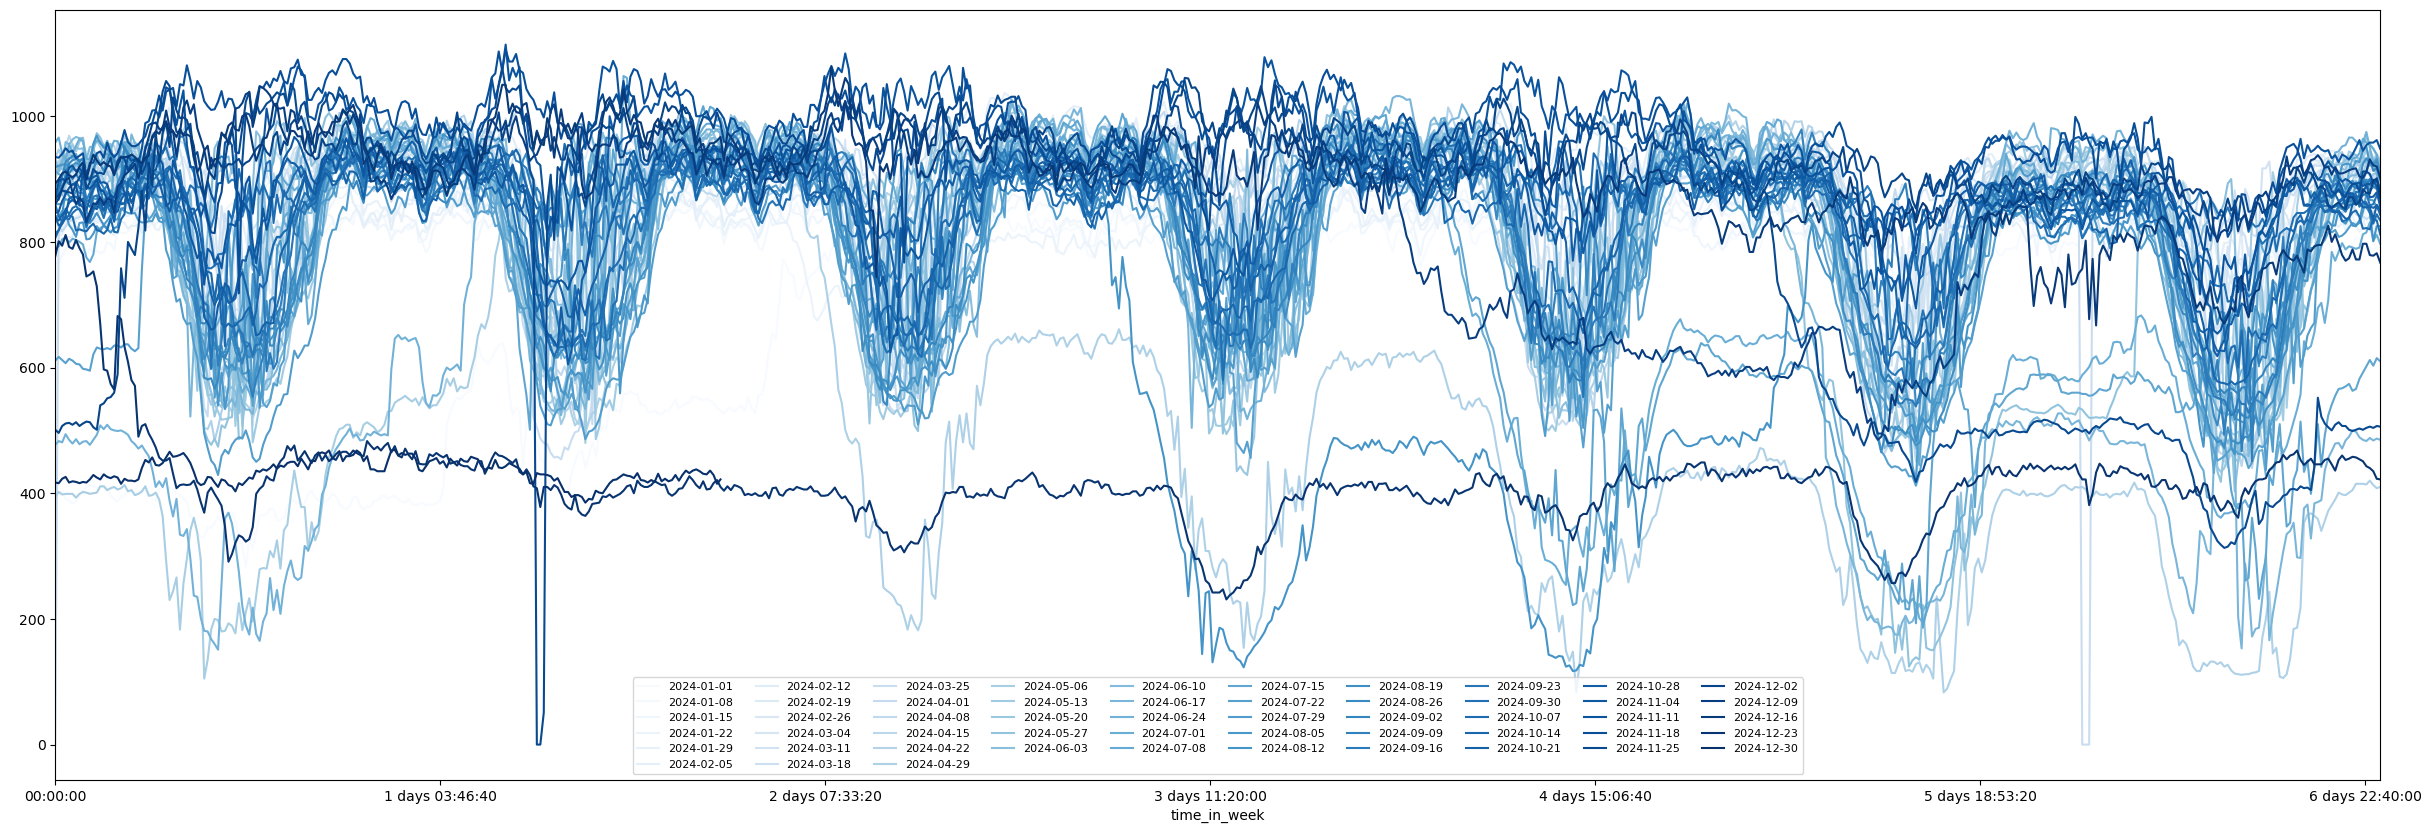

In [7]:
df = ea.index.to_frame()
df['week'] = ea.index.to_period('W').start_time
df['time_in_week'] = df['time'] - df['week']
idx = pd.MultiIndex.from_frame(df)
df = ea.copy()
df.index = idx
df = df.droplevel('time')
zz = df['Statia Jucu 1'].unstack('week')
zz.index.freq='15min'
ax = zz.plot(figsize=(30, 10), colormap='Blues')
legend = ax.legend(loc='lower center', prop={'size': 8}, ncols=10)
for t in legend.get_texts():
    t.set_text(t.get_text()[:-len(' 00:00:00')])

# Reactive energy usage

Se utulizieaza:
1. Observi ca ER- creste puternic in Mai
2. Faci zoom in pe luna Mai si investighezi mai in detaliu

In [8]:
sj = 'Statia Jucu 1'
df = tetarom_df.loc[:, pd.IndexSlice[:, 'Statia Jucu 1']].copy().droplevel('location', axis=1)
df['EA'] = df['EA+'] - df['EA-']
df = df[['EA', 'ER+', 'ER-']]

<Axes: xlabel='time'>

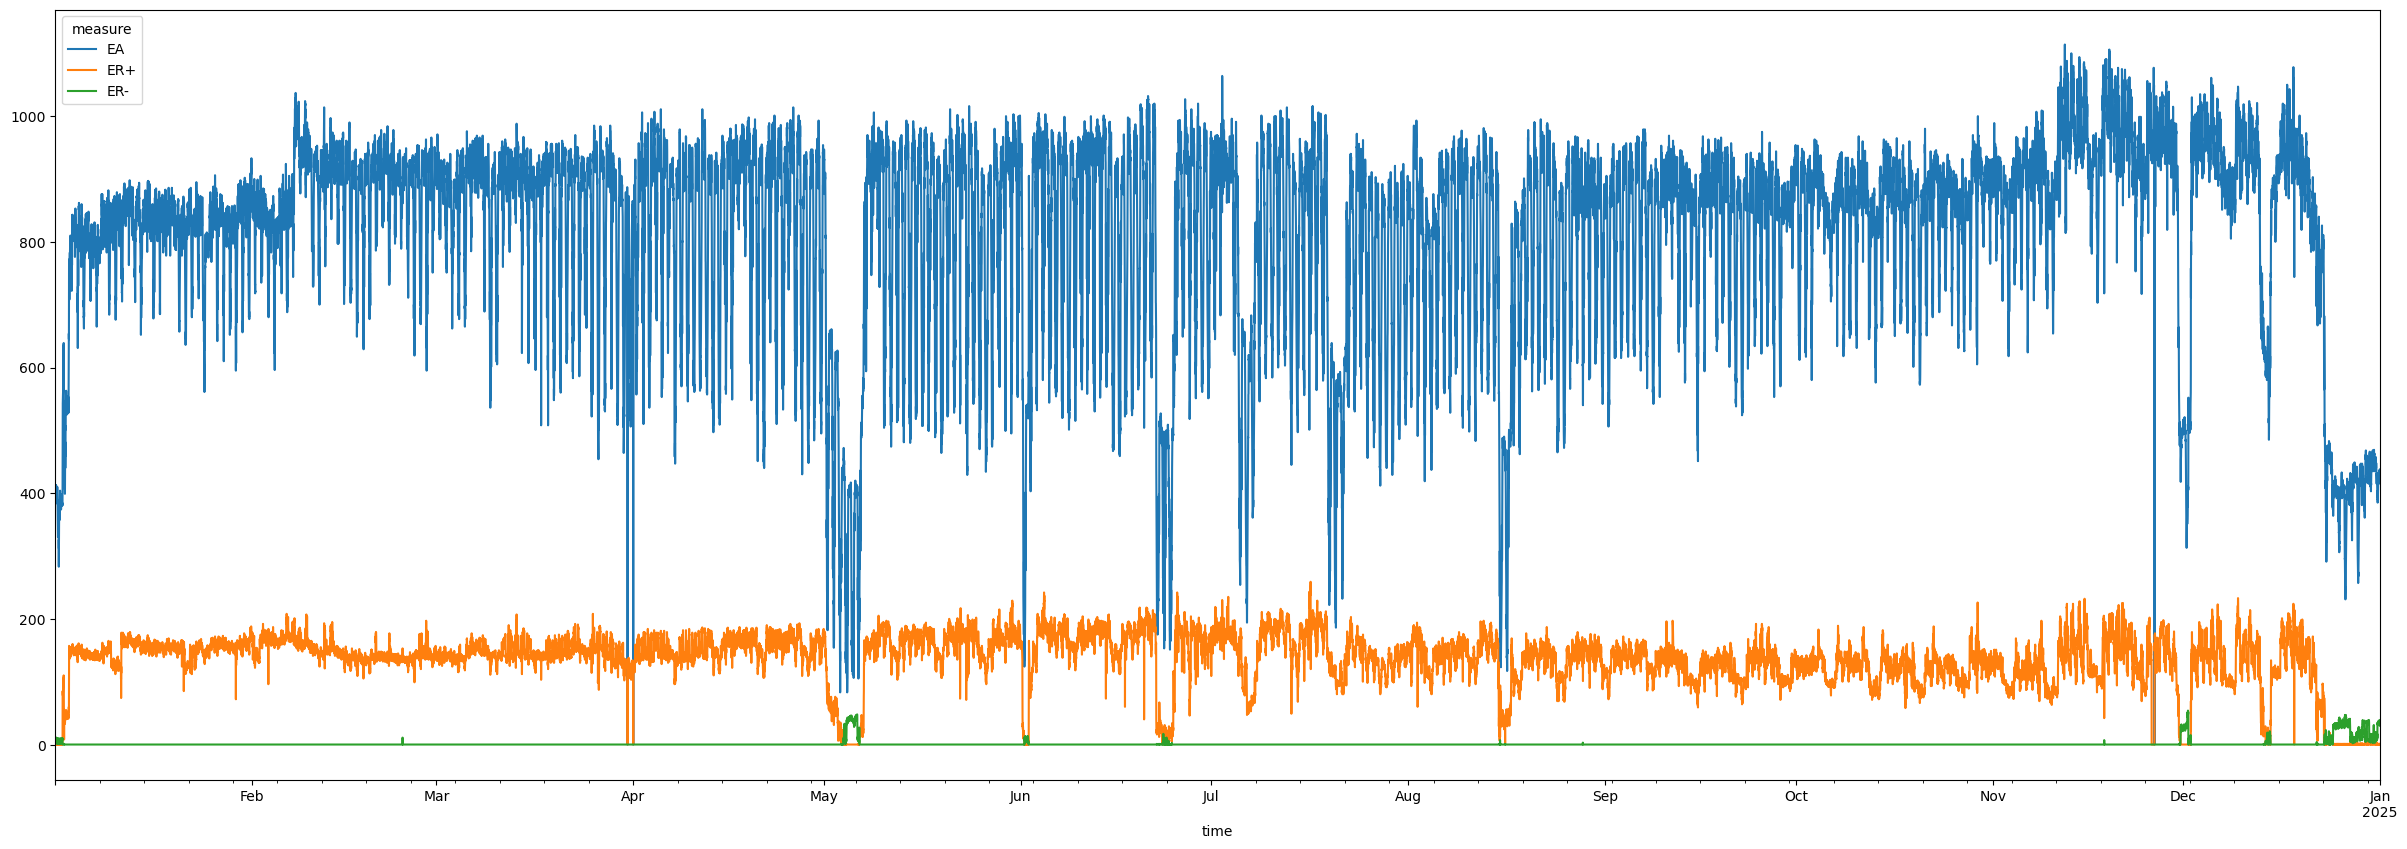

In [9]:
df.plot(figsize=(30, 10))

# Reactive energy %age usage

Scopul e sa vedem cat de aproape e ER+/- %age de prima limita.  
Din nou, zoom in sa investigam.

Todo:
- Cand trece de prima limita, linia sa fie colorata rosu

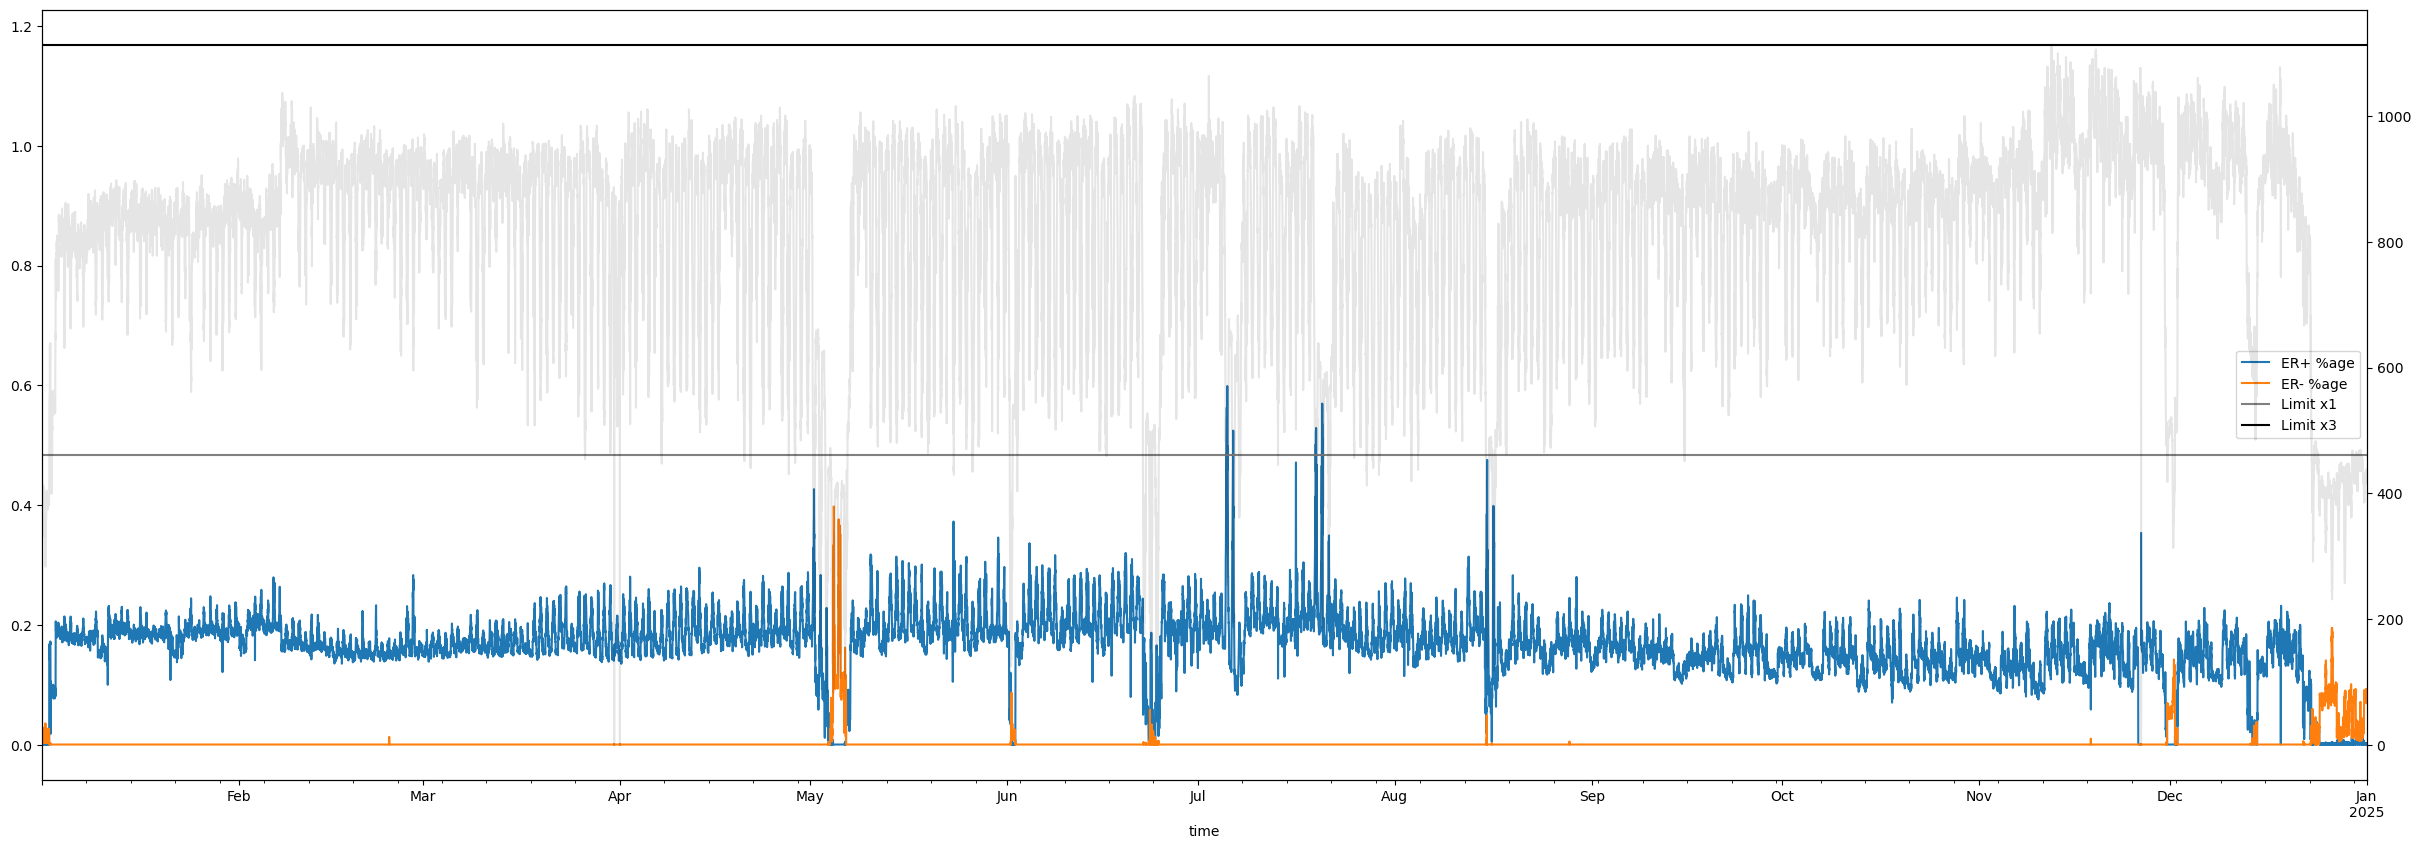

In [10]:
limit_x1 = 0.4843
limit_x3 = 1.1691

erpc = pd.DataFrame({
    'ER+ %age': df['ER+'] / df['EA'],
    'ER- %age': df['ER-'] / df['EA'],
    'EA': df['EA']
})
ax = erpc.plot(figsize=(30, 10), secondary_y='EA')
ea_line = ax.figure.axes[1].lines[0]
ea_line.set_alpha(.1)
ea_line.set_color('black')
ax.axhline(limit_x1, color='gray', label='Limit x1')
ax.axhline(limit_x3, color='black', label='Limit x3')
ax.legend()